# OLG Homework

Natasha Watkins

In [11]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt
import time

### Exercise 2.1

In [12]:
β = 0.442
δ = 0.6415
σ = 3
A = 1
α = 0.35

nvec = np.array([1, 1, 0.2])
n1, n2, n3 = nvec

f_params = (nvec, A, α, δ)
bvec_guess = np.array([1.0, 2.0])

u = lambda c: (c**(1 - σ) - 1) / (1 - σ)   # CRRA utility
u_prime = lambda c: c**(-σ)                # First derivative of u

In [13]:
w = lambda α, A, L, K: (1 - α) * A * (K / L)**α
r = lambda α, A, L, K, δ: α * A * (L / K)**(1 - α) - δ

In [14]:
def feasible(f_params, bvec_guess):
    
    nvec, A, α, δ = f_params  # Unpack parameters
    K = np.sum(bvec_guess)    # Total capital
    L = np.sum(nvec)          # Total labour
    
    b_cnstr, c_cnstr = np.zeros(2, dtype=bool), np.empty(3, dtype=bool)
    K_cnstr = np.zeros(1, dtype=bool)  # Default to False
    
    K_cnstr[0] = K <= 0
    
    w_t = w(α, A, L, K)     # Equilibrium wage rate
    r_t = r(α, A, L, K, δ)  # Equilibrium interest rate
            
    c1 = nvec[0] * w_t - bvec_guess[0]
    c2 = nvec[1] * w_t + (1 + r_t) * bvec_guess[0] - bvec_guess[1]
    c3 = nvec[2] * w_t + (1 + r_t) * bvec_guess[1]
    
    c = np.array([c1, c2, c3])  # Consumption path
    c_cnstr = c <= 0
    
    if c_cnstr[0]:              # If c1 <= 0
        b_cnstr[0] = True
    elif c_cnstr[1]:            # If c2 <= 0, set both elements to true
        b_cnstr[:] = True
    elif c_cnstr[2]:            # If c3 <= 0
        b_cnstr[1] = True
    
    return b_cnstr, c_cnstr, K_cnstr

**Question a)**

In [15]:
bvec_guess = np.array([1.0, 1.2])
feasible(f_params, bvec_guess)

(array([ True, False]), array([ True, False, False]), array([False]))

The time-1 budget constraint is violated.

**Question b)**

In [16]:
bvec_guess = np.array([0.06, -0.001])
feasible(f_params, bvec_guess)

(array([False, False]), array([False, False, False]), array([False]))

No budget constraints are violated.

**Question c)**

In [17]:
bvec_guess = np.array([0.1, 0.1])
feasible(f_params, bvec_guess)

(array([False, False]), array([False, False, False]), array([False]))

No budget constraints are violated.

### Exercise 2.2

**Part a)**

In [18]:
euler_b2 = lambda w, r, b2, b3: u_prime(n1 * w - b2) - \
           β * (1 + r) * u_prime(n2 * w + (1 + r) * b2 - b3)
euler_b3 = lambda w, r, b2, b3: u_prime(n2 * w + (1 + r) * b2 - b3) - \
           β * (1 + r) * u_prime((1 + r) * b3 + n3 * w)

In [19]:
SS_tol = 1e-5
params = (β, σ, nvec, A, α, δ, SS_tol)

def get_SS(params, bvec_guess, SS_graphs=False):
    
    start_time = time.clock()  # Start timing
    
    β, σ, nvec, A, α, δ, SS_tol = params
    n1, n2, n3 = nvec  # Labour supply in each period
    L = np.sum(nvec)   # Total labour supply
    
    def equations(bvec):
        b2, b3 = bvec
        K = np.sum(bvec)        # Total capital
        w_t = w(α, A, L, K)     # Equilibrium wage rate
        r_t = r(α, A, L, K, δ)  # Equilibrium interest rate
        eq1 = euler_b2(w_t, r_t, b2, b3)
        eq2 = euler_b3(w_t, r_t, b2, b3)
        return eq1, eq2
    
    b_ss = root(equations, x0=bvec_guess, tol=SS_tol).x  # Solve for steady state b
    K_ss = np.sum(b_ss)         # Steady state capital
    w_ss = w(α, A, L, K_ss)     # Steady state wage
    r_ss = r(α, A, L, K_ss, δ)  # Steady state interest rate
    
    # Back out consumption path
    c_1 = n1 * w_ss - b_ss[0]
    c_2 = n2 * w_ss + (1 + r_ss) * b_ss[0] - b_ss[1]
    c_3 = n3 * w_ss + (1 + r_ss) * b_ss[1]
    c_ss = np.array([c_1, c_2, c_3])  # Steady state consumption path
    C_ss = c_ss.sum()                 # Total steady state consumption
    
    # Back out steady state investment path
    I_ss = (b_ss[1] - (1 - δ) * b_ss[0]).sum()
    
    Y_ss = C_ss + I_ss  # Total output
    
    # Euler errors
    EulErr_ss = β * (1 + r_ss) * u_prime(c_ss[1:]) - u_prime(c_ss[:-1])

    # Resource contraint error
    RCerr_ss = Y_ss - C_ss - δ * K_ss

    ss_time = time.clock() - start_time  # Stop timing
    
    ss_output = {'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
                 'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
                 'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
                 'ss_time': ss_time}
    
    if SS_graphs:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        axes[0].bar(range(2, 4), b_ss)
        axes[0].set(xticks=([2, 3]), xlabel='State', title='Steady state $b_t$')
        axes[1].bar(range(1, 4), c_ss)
        axes[1].set(xticks=([1, 2, 3]), xlabel='State', title='Steady state $c_t$')
        plt.tight_layout()
        plt.show()
    
    return ss_output

In [20]:
ss = get_SS(params, np.array([0.1, 0.1]))
ss

{'C_ss': 0.6329006782167177,
 'EulErr_ss': array([ 4.50781670e-06, -8.92472291e-06]),
 'K_ss': 0.0777236279220895,
 'RCerr_ss': 0.0016278487132806718,
 'Y_ss': 0.6843882342420188,
 'b_ss': array([0.01931253, 0.0584111 ]),
 'c_ss': array([0.18241213, 0.20961468, 0.24087387]),
 'r_ss': 2.433062283358659,
 'ss_time': 0.0005409999999996806,
 'w_ss': 0.20172465936076353}

**Part b)**

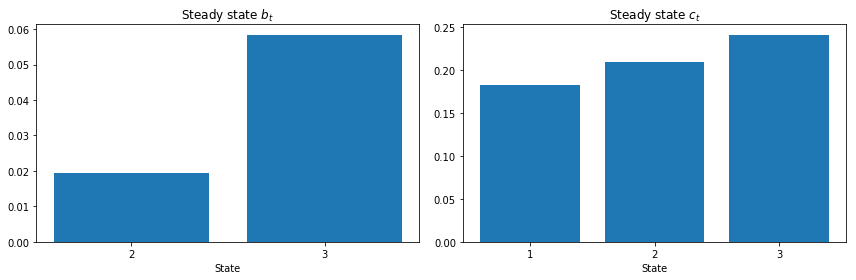

In [21]:
ss = get_SS(params, np.array([0.1, 0.1]), SS_graphs=True)

**Part c)**

In [22]:
β = 0.55
params = (β, σ, nvec, A, α, δ, SS_tol)
get_SS(params, np.array([0.1, 0.1]))

{'C_ss': 0.691284290244305,
 'EulErr_ss': array([6.82726977e-08, 2.51137209e-08]),
 'K_ss': 0.10504237016721853,
 'RCerr_ss': -0.0006206546125954587,
 'Y_ss': 0.7580483160939803,
 'b_ss': array([0.02817692, 0.07686545]),
 'c_ss': array([0.19597528, 0.22861594, 0.26669307]),
 'r_ss': 1.8863765066381661,
 'ss_time': 0.00030200000000002447,
 'w_ss': 0.2241521958905792}

A higher $\beta$ increases consumption and investment in every period. The equilibrium wage rate is higher, while the interest rate is lower.

Increasing $\beta$ results in an receiving greater utility from comsumption in the future than previously, and therefore is likely to consume less today and save a greater proportion of income, resulting in greater investment and a higher steady state capital level.

### Problem 2.3

In [35]:
T = 30
β = 0.442
δ = 0.6415
σ = 3
A = 1
α = 0.35
nvec = np.array([1, 1, 0.2])
n1, n2, n3 = nvec
L = np.sum(nvec)
bbar2, bbar3 = ss['b_ss']
Kbar = ss['K_ss']                     # Steady state capital

b21, b31 = 0.8 * bbar2, 1.1 * bbar3
K1 = b21 + b31

euler_b2 = lambda w1, w2, r2, b2, b3: u_prime(n1 * w1 - b2) - \
           β * (1 + r2) * u_prime(n2 * w2 + (1 + r2) * b2 - b3)
euler_b3 = lambda w2, w3, r2, r3, b2, b3: u_prime(n2 * w2 + (1 + r2) * b2 - b3) - \
           β * (1 + r3) * u_prime((1 + r3) * b3 + n3 * w3)

In [36]:
def find_b2t2_b3t3(bvec, w1, w2, w3, r2, r3):
    
    b2t2, b3t3 = bvec
    
    e1 = euler_b2(w1, w2, r2, b2t2, b3t3)
    e2 = euler_b3(w2, w3, r2, r3, b2t2, b3t3)
    
    return np.array([e1, e2]).flatten()

In [161]:
def update_bmat(b21, b31, K, bmat, T, m):
        
    w_t = w(α, A, L, K)
    r_t = r(α, A, L, K, δ)
    
    for t in range(1, T+m-2):
        
        w1, w2, w3 = w_t[t-1], w_t[t], w_t[t+1]
        r2, r3 = r_t[t], r_t[t+1]
        
        b2t1 = bmat[t-1, 0]
        b3t1 = bmat[t-1, 1]
        b3t2 = bmat[t, 1]
        b2t2, b3t3 = root(find_b2t2_b3t3, 
                          np.zeros(2), 
                          args=(w1, w2, w3, r2, r3)).x
        bmat[t, 0] = b2t2
        bmat[t+1, 1] = b3t3
        
    return bmat

In [162]:
def find_b32(b32, b21, w1, w2, r1, r2):
    return euler_b3(w1, w2, r1, r2, b21, b32)

In [163]:
def find_ss_path(b21, b31, T, ξ=0.2, ɛ=1e-9, max_iter=100):
    
    m = 3
    dist = 1e3
    i = 0
    K = np.linspace(K1, Kbar, T+m)     # Initial guess at K
    
    # Initialise a matrix to store b's
    bmat = np.zeros((T+m, 2))
    bmat[0, :] = b21, b31
    
    # Solve for the value of b32

    w_t = w(α, A, L, K)
    r_t = r(α, A, L, K, δ)

    bmat[1, 1] = root(find_b32, 0, args=(b21, w_t[0], w_t[1], r_t[0], r_t[1])).x
    
    while (i < max_iter) and (dist > ɛ):        
        bmat = update_bmat(b21, b31, K, bmat, T, m)
        K_prime = bmat.sum(axis=1)
        dist = ((K_prime - K)**2).sum()
        K = ξ * K_prime + (1 - ξ) * K
        i += 1
     
    if dist < ɛ:
        print(f'Converged in {i} iterations')
    else:
        print('Did not converge')
    
    return K[:-m], bmat[:-1]  # Solved past the steady state

In [164]:
K_star = find_ss_path(b21, b31, 20)

Converged in 44 iterations


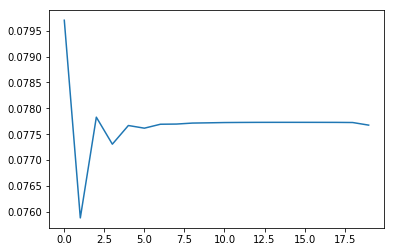

In [165]:
plt.plot(K_star[0])
plt.show()

In [166]:
K_star[1]

array([[0.01545002, 0.06425221],
       [0.0202736 , 0.05561004],
       [0.01875105, 0.05907837],
       [0.01943275, 0.05787443],
       [0.01920357, 0.05846354],
       [0.01931966, 0.05829506],
       [0.01928836, 0.05840168],
       [0.01930975, 0.05838316],
       [0.01930668, 0.05840496],
       [0.01931121, 0.05840505],
       [0.01931144, 0.0584103 ],
       [0.01931257, 0.05841137],
       [0.01931284, 0.05841277],
       [0.01931314, 0.05841322],
       [0.01931323, 0.05841352],
       [0.01931329, 0.05841357],
       [0.01931328, 0.05841353],
       [0.01931319, 0.05841339],
       [0.01931147, 0.05841286],
       [0.0192705 , 0.05840319],
       [0.01828807, 0.05817081],
       [0.        , 0.05254753]])

In [81]:
K_star[0]

array([0.07970223, 0.07588206, 0.0778295 , 0.07730765, 0.07766859,
       0.07761702, 0.0776931 , 0.07769654, 0.07771559, 0.07772032,
       0.0777257 , 0.07772769, 0.07772906, 0.07772946, 0.0777295 ,
       0.07772916, 0.07772673, 0.0776762 , 0.07646408])